## Focus Fiduciary Check
**Author:** [Aaron Woods](https://aaronwoods.info)<br>
**Date created:** 2023/09/11<br>
**Description:** This script demonstrates how to build a binary classifier model for the task of classifying images as "In Focus" or "Out of Focus".
https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification

## Setup

In [1]:
%pip install numpy pandas matplotlib protobuf seaborn scikit-learn opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [3]:
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Anything above 2.10 is not supported on the GPU on Windows Native
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Standard Libraries
import os
import sys
import random
import math
from datetime import datetime
import logging
import glob 

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import defaultdict
from typing import List, Dict, Tuple, Union, Any, Optional

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
import pickle

In [6]:
# Import necessary libraries and initialize an empty dictionary for system info
import platform
system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}

# Try to import TensorFlow and gather related information
try:
    import tensorflow as tf
    system_info.update({
        "TensorFlow Version": tf.__version__,
        "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
    })
    system_info['Instructions'] = "You're all set to run your model on a GPU." if system_info['Num GPUs Available'] else (
        "No GPUs found. To use a GPU, follow these steps:\n"
        "  1. Install NVIDIA drivers for your GPU.\n"
        "  2. Install a compatible CUDA toolkit.\n"
        "  3. Install the cuDNN library.\n"
        "  4. Make sure to install the GPU version of TensorFlow."
    )
except ModuleNotFoundError:
    system_info['Instructions'] = "TensorFlow is not installed. Install it using pip by running: !pip install tensorflow"

# Format and display the information
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)


Platform: Windows-10-10.0.17763-SP0
Python Version: 3.9.18
TensorFlow Version: 2.10.1
Num GPUs Available: 1
Instructions: You're all set to run your model on a GPU.


## Configuration

In [8]:
# @title Configuration

# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "Multi-Label_Thresholds-30-60-1-2",
        'RANDOM_SEED': 42,
        'PROBLEM_TYPE': 'Multi-Label', # Binary, Multi-Class, Multi-Label
    },
    'Model': {
        'IMG_SIZE': 224,
        'BATCH_SIZE': 32,
        'EPOCHS': 100,
        'LEARNING_RATE': 1e-3,
        'EARLY_STOPPING_PATIENCE': 5,
        'REDUCE_LR_PATIENCE': 3,
        'MIN_LR': 1e-6,
        'LOSS': "categorical_crossentropy",  # Updated for multi-class
        'TRAIN_SIZE': 0.8,
        'VAL_SIZE': 0.5,
    },
    'Thresholds': {
        'FOCUS_LOW': 30,
        'FOCUS_HIGH': 60,
        'STIG_LOW': 1,
        'STIG_HIGH': 2,
    },
    'Labels': {
        'MAPPINGS': {
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Paths': {
        'BASE_DIR': "Y:\\User\\Aaron-HX38\\DOE\\",
        'DATA_FILE': "combined_output.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\",
    },
    'Augmentation': {
        'rotation_factor': 0.002,
        'height_factor': (-0.18, 0.18),
        'width_factor': (-0.18, 0.18),
        'contrast_factor': 0.5,
    }
}

# Random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Defining the Models

In [9]:

def determine_activation_and_units(num_classes: int) -> tuple:
    """Determine the activation function and units based on number of classes and problem type from config."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type == 'Multi-Label':
        return "sigmoid", num_classes
    elif problem_type == 'Binary' or num_classes == 2:
        return "sigmoid", 1
    elif problem_type == 'Multi-Class':
        return "softmax", num_classes
    else:
        raise ValueError(f"Invalid problem_type: {problem_type}")


In [10]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
        
    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

In [11]:
# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activation, units = determine_activation_and_units(num_classes)

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

In [12]:
# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model


In [13]:
# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

## Load and Preprocess the data

### Image Processing Functions

In [14]:
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import tensorflow as tf
from typing import Tuple

def create_preprocessing_layers(img_width: int, img_height: int, rescale_factor: float) -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    return keras.Sequential([
        layers.Resizing(img_width, img_height),
        layers.Rescaling(rescale_factor)
    ])


def create_augmentation_layers(augmentation_config: dict) -> keras.Sequential:
    """Create data augmentation layers."""
    try:
        augmentation_layers = tf.keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(augmentation_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=augmentation_config['height_factor'],
                width_factor=augmentation_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(augmentation_config['contrast_factor']),
        ])
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
    return augmentation_layers


def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    print("Reading image from:", file_path)
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)


def preprocess_image(file_path, label, augment, config: dict) -> Tuple[tf.Tensor, tf.Tensor]:
    """Preprocess an image by applying resizing, rescaling, and optional data augmentation."""
    file_path = file_path.numpy().decode("utf-8")
    preprocess_seq = create_preprocessing_layers(
        img_width=config['Model']['IMG_SIZE'], 
        img_height=config['Model']['IMG_SIZE'], 
        rescale_factor=1./255
    )
    augment_seq = create_augmentation_layers(config['Augmentation'])
    image = read_and_convert_image(file_path)
    if image is None:
        print("Image reading failed.")
        return None, label
    image = preprocess_seq(image)
    if augment:
        image = augment_seq(image)
        image = tf.clip_by_value(image, 0, 1)  # Clip values after augmentation
    return image, label


def preprocess_wrapper(file_path, label, augment, config: dict) -> Tuple[tf.Tensor, tf.Tensor]:
    image, label = tf.py_function(
        func=lambda file_path, label, augment: preprocess_image(file_path, label, augment, config),
        inp=[file_path, label, augment], 
        Tout=[tf.float32, tf.int32]
    )
    image.set_shape([config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3])
    label.set_shape([9])  # This should match the length of your multi-label
    return image, label

def preprocess_images(train_ds, valid_ds, test_ds, config: dict):
    """Apply preprocessing to training, validation, and test datasets."""
    train_ds = train_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, True, config))
    valid_ds = valid_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, False, config))
    test_ds = test_ds.map(lambda file_path, label: preprocess_wrapper(file_path, label, False, config))
    return train_ds, valid_ds, test_ds






### Functions for Preparation of CSV

In [15]:
# Data Preprocessing and Dataset Preparation

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.data import Dataset
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight


def preprocess_and_prepare_tf_datasets(config: dict) -> dict:
    """Preprocess a CSV data file and prepare TensorFlow datasets."""
    
    print("===== Preprocessing CSV Data =====")
    
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['BASE_DIR'], config['Paths']['DATA_FILE'])
    print(f"---> Reading data from: {data_file_path}")
    
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    
    try:
        data = pd.read_csv(data_file_path)
        print("---> Data read successfully.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    
    # Functionality to update image paths
    print("---> Updating image file paths...")
    data['ImageFile'] = data['ImageFile'].str.replace(config['Paths']['OLD_BASE_PATH'], config['Paths']['NEW_BASE_PATH'], regex=False)
    print("---> Image paths updated.")
    # === New Code Starts ===
    # Create a DataFrame for storing offset values
    offset_values_df = data[['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].copy()
    # === New Code Ends ===
    # Functionality to generate labels for Focus, StigX, and StigY
    print("---> Generating labels for Focus, StigX, and StigY...")
    focus_conditions = [
        (data['Focus_Offset (V)'].abs() <= config['Thresholds']['FOCUS_LOW']),
        (data['Focus_Offset (V)'].abs() <= config['Thresholds']['FOCUS_HIGH']),
        (data['Focus_Offset (V)'].abs() > config['Thresholds']['FOCUS_HIGH'])]
    stig_x_conditions = [
        (data['Stig_Offset_X (V)'].abs() <= config['Thresholds']['STIG_LOW']),
        (data['Stig_Offset_X (V)'].abs() <= config['Thresholds']['STIG_HIGH']),
        (data['Stig_Offset_X (V)'].abs() > config['Thresholds']['STIG_HIGH'])]
    stig_y_conditions = [
        (data['Stig_Offset_Y (V)'].abs() <= config['Thresholds']['STIG_LOW']),
        (data['Stig_Offset_Y (V)'].abs() <= config['Thresholds']['STIG_HIGH']),
        (data['Stig_Offset_Y (V)'].abs() > config['Thresholds']['STIG_HIGH'])]
    focus_choices = list(config['Labels']['MAPPINGS']['Focus_Label'].keys())
    stig_x_choices = list(config['Labels']['MAPPINGS']['StigX_Label'].keys())
    stig_y_choices = list(config['Labels']['MAPPINGS']['StigY_Label'].keys())
    data['Focus_Label'] = np.select(focus_conditions, focus_choices)
    data['StigX_Label'] = np.select(stig_x_conditions, stig_x_choices)
    data['StigY_Label'] = np.select(stig_y_conditions, stig_y_choices)
    print("---> Labels generated.")
    data['Multi_Labels'] = data.apply(lambda row: [row['Focus_Label'], row['StigX_Label'], row['StigY_Label']], axis=1)
    print("---> Multi-labels generated.")
    
    print("===== Preparing TensorFlow Datasets =====")
    
    # Multi-label binarization
    mlb = MultiLabelBinarizer()
    data['Multi_Labels_Binarized'] = list(mlb.fit_transform(data['Multi_Labels']))

    # Shuffle and Reset Index
    print("---> Shuffling and resetting index...")
    labeled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    
    

    # Split Data
    train_df, temp_df = train_test_split(labeled_df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])

    # Create an empty dictionary to store datasets and info
    datasets = {'train': None, 'valid': None, 'test': None, 'info': {'Training': {}, 'Validation': {}, 'Test': {}}}

    # Create TensorFlow Datasets
    train_ds = Dataset.from_tensor_slices((train_df['ImageFile'].values, list(train_df['Multi_Labels_Binarized'])))
    val_ds = Dataset.from_tensor_slices((val_df['ImageFile'].values, list(val_df['Multi_Labels_Binarized'])))
    test_ds = Dataset.from_tensor_slices((test_df['ImageFile'].values, list(test_df['Multi_Labels_Binarized'])))
    
 
    # Apply Preprocessing using your preprocessing functions
    train_ds, val_ds, test_ds = preprocess_images(train_ds, val_ds, test_ds, config)


    # Store Datasets
    datasets['train'] = train_ds
    datasets['valid'] = val_ds
    datasets['test'] = test_ds

    # Compute and Store Class Weights and Info for each split
    for label in range(len(mlb.classes_)):
        for split, df in zip(['Training', 'Validation', 'Test'], [train_df, val_df, test_df]):
            # Extract the column for the current label from the multi-label binarized labels
            label_column = df['Multi_Labels_Binarized'].apply(lambda x: x[label])

            # Compute class weights
            unique_labels = np.unique(label_column)  # In the binarized label, each label can be either 0 or 1
            class_weights = compute_class_weight('balanced', classes=unique_labels, y=label_column)
            class_weights_dict = dict(zip(unique_labels, class_weights))
            
            # Store the class weights and other info
            datasets['info'][split][mlb.classes_[label]] = {
                'Total': len(df),
                'ClassInfo': {cls: {'Count': cnt, 'Weight': class_weights_dict.get(cls, 0)} for cls, cnt in Counter(label_column).items()}
            }
    # === New Code Starts ===
    # Store the offset values DataFrame in the datasets dictionary
    datasets['offset_values'] = offset_values_df
    # === New Code Ends ===

    print("===== Preprocessing and Dataset Preparation Complete =====")
    
    return datasets


# Preprocess and prepare datasets
dataset = preprocess_and_prepare_tf_datasets(config)


===== Preprocessing CSV Data =====
---> Reading data from: Y:\User\Aaron-HX38\DOE\combined_output.csv


C:\Users\User\AppData\Local\Temp\ipykernel_17096\3442967451.py:30: DtypeWarning: Columns (22,27,28,42) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_file_path)


---> Data read successfully.
---> Updating image file paths...
---> Image paths updated.
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated.
---> Multi-labels generated.
===== Preparing TensorFlow Datasets =====
---> Shuffling and resetting index...
---> Data shuffled and index reset.
===== Preprocessing and Dataset Preparation Complete =====


In [16]:
print(dataset['train'].element_spec)


(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int32, name=None))


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import pprint 
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(dataset)

{   'info': {   'Test': {   'HighlyBlurred': {   'ClassInfo': {   0: {   'Count': 1406,
                                                                         'Weight': 0.6834992887624467},
                                                                  1: {   'Count': 516,
                                                                         'Weight': 1.8624031007751938}},
                                                 'Total': 1922},
                            'ModerateStig_X': {   'ClassInfo': {   0: {   'Count': 1524,
                                                                          'Weight': 0.6305774278215223},
                                                                   1: {   'Count': 398,
                                                                          'Weight': 2.4145728643216082}},
                                                  'Total': 1922},
                            'ModerateStig_Y': {   'ClassInfo': {   0: {   'Count': 1535,
        

## Visualize the data

### Class Weights

c:\Users\User\miniconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\User\miniconda3\envs\tf\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

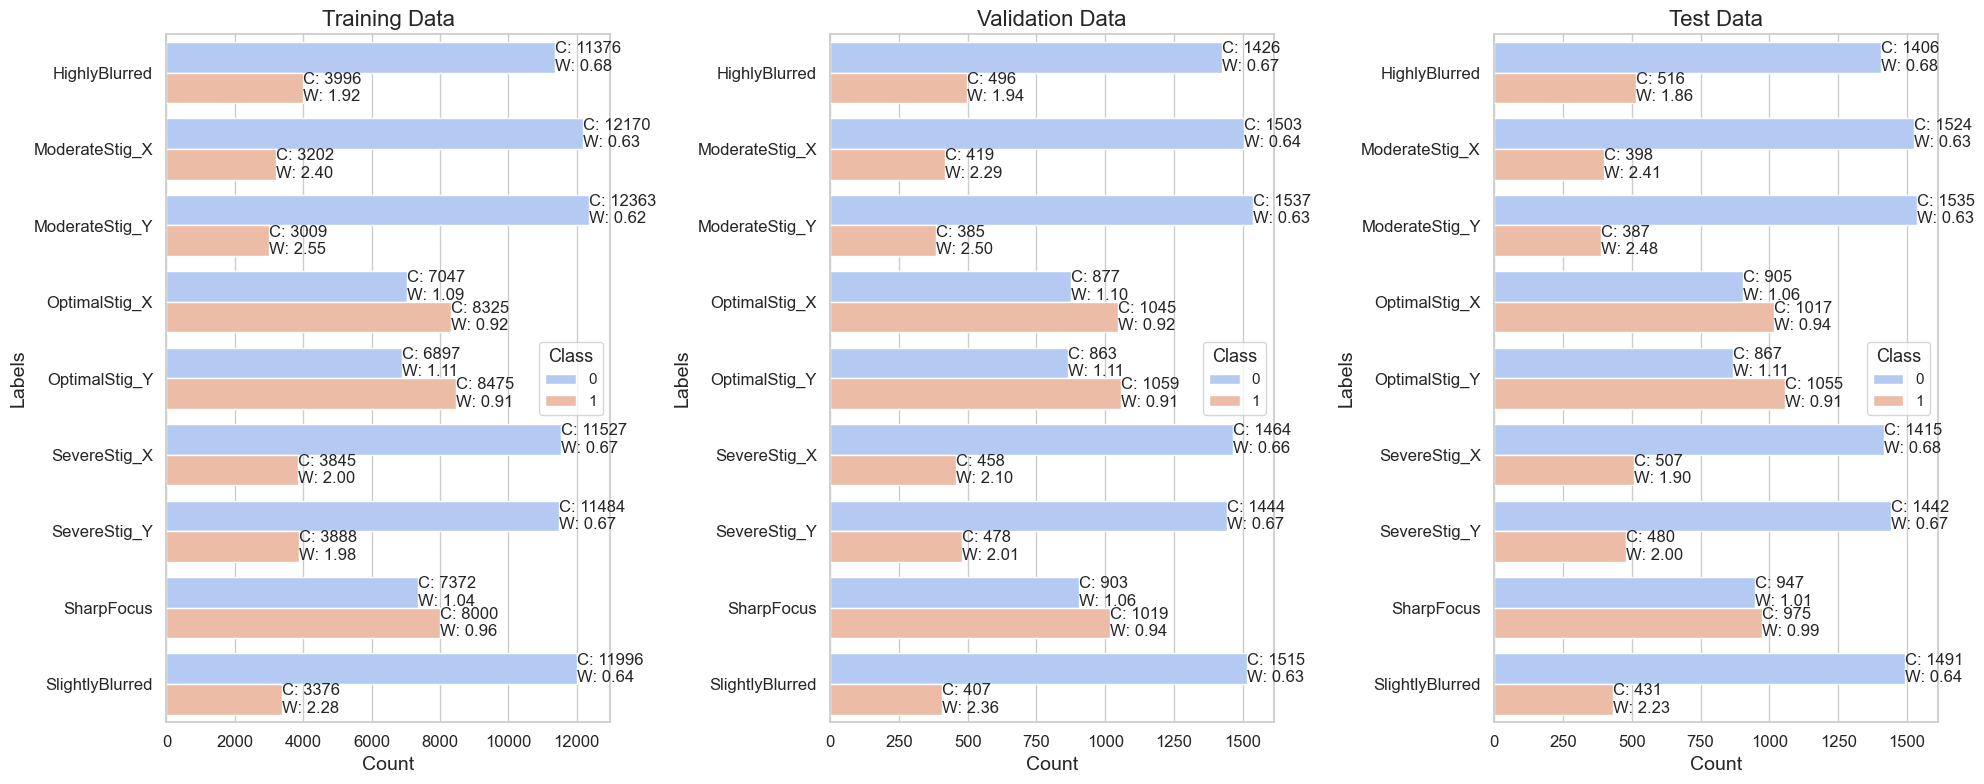

In [18]:
from typing import Dict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_single_split(ax, dataset_info: Dict, split: str) -> None:
    # Prepare a DataFrame for seaborn
    data = []
    for label_column, label_info in dataset_info[split].items():
        data.extend(
            {
                'Label': label_column,
                'Class': str(class_label),
                'Count': class_info['Count'],
                'Weight': class_info['Weight'],
            }
            for class_label, class_info in label_info['ClassInfo'].items()
        )
    df = pd.DataFrame(data)

    # Plotting
    sns.barplot(data=df, y='Label', hue='Class', x='Count', ax=ax, palette="coolwarm")

    # Annotating the bars with counts and weights
    for p in ax.patches:
        ax.annotate(f"C: {int(p.get_width())}\nW: {df.loc[p.get_bbox().x1.round(1) == df['Count'], 'Weight'].values[0]:.2f}", 
                    (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', va='center')

    # Setting titles and labels
    ax.set_title(f"{split} Data", fontsize=16)
    ax.set_ylabel('Labels', fontsize=14)
    ax.set_xlabel('Count', fontsize=14)
    ax.tick_params(labelsize=12)
    ax.legend(title='Class', title_fontsize='13', fontsize='11')

def plot_dataset_info(datasets: Dict) -> None:
    """Plot a single figure with subplots for training, validation, and test sets."""
    sns.set(style="whitegrid")
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    
    for i, split in enumerate(['Training', 'Validation', 'Test']):
        plot_single_split(axs[i], datasets['info'], split)
    
    plt.tight_layout()
    plt.show()

# Call the function using your 'datasets' dictionary
plot_dataset_info(dataset)



### See Batches

## Define the Callbacks

### Defining Models and Callbacks

In [19]:
from tensorflow.keras.metrics import (
    TruePositives, FalsePositives, TrueNegatives, FalseNegatives,
    Precision, Recall, AUC
)
from typing import List, Tuple
from datetime import datetime
from tensorflow.keras import callbacks as keras_callbacks
from tensorflow.keras.callbacks import TensorBoard
import os

# Metrics Configuration
def get_per_class_metrics(num_classes: int) -> List[str]:
    """Generate a list of metrics for each class."""
    metrics = ["accuracy"]
    
    for i in range(num_classes):
        metrics.extend([
            TruePositives(name=f"true_positives_class_{i}"),
            FalsePositives(name=f"false_positives_class_{i}"),
            TrueNegatives(name=f"true_negatives_class_{i}"),
            FalseNegatives(name=f"false_negatives_class_{i}"),
            Precision(name=f"precision_class_{i}"),
            Recall(name=f"recall_class_{i}"),
            AUC(name=f"auc_class_{i}")
        ])
        
    return metrics


# Constants and Directories
BASE_DIR = os.path.expanduser("~")
MODELS_DIR_NAME = "models"
LOG_DIR_NAME = "logs/fit"
DEFAULT_INPUT_SHAPE = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
DEFAULT_NUM_CLASSES = 3


# Model Configurations
MODEL_CONFIGS = {
    'mobilenetv2': {'model_fn': create_mobilenetv2_transfer_model},
    'small_xception': {'model_fn': create_small_xception_model},
    'basic_cnn': {'model_fn': create_basic_cnn_model},
    'inceptionv3': {'model_fn': create_inceptionv3_transfer_model},
    'resnet50': {'model_fn': create_resnet50_transfer_model}
}

# Initialize model configs with default values
for config_name in MODEL_CONFIGS:
    MODEL_CONFIGS[config_name].setdefault('input_shape', DEFAULT_INPUT_SHAPE)
    MODEL_CONFIGS[config_name].setdefault('num_classes', DEFAULT_NUM_CLASSES)


# Helper Functions
def create_directory(path: str) -> None:
    """Create directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)

def generate_log_and_checkpoint_dirs(model_name: str, label_column: str) -> Tuple[str, str]:
    """Generate directories for logs and checkpoints based on the experiment name."""
    
    # Retrieve experiment name from the config dictionary
    experiment_name = config['Experiment']['NAME']
    
    # Create the model directory path
    model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME, experiment_name, f"{label_column}_models", f"{model_name}_models")
    
    # Create the directory if it doesn't exist
    create_directory(model_dir)

    # Create the log directory path
    log_dir = os.path.join(model_dir, LOG_DIR_NAME, f"{model_name}_{datetime.now().strftime('%Y%m%d-%I%M%S%p')}")
    
    # Create the directory if it doesn't exist
    create_directory(log_dir)

    # Generate the checkpoint file name
    checkpoint_filename = f'model-{datetime.now().strftime("%Y%m%d-%I%M%S%p")}-{{epoch:02d}}-loss{{val_loss:.2f}}-acc{{val_accuracy:.2f}}.h5'
    checkpoint_path = os.path.join(model_dir, checkpoint_filename)

    return log_dir, checkpoint_path



# Callbacks
def define_callbacks(model_name: str, label_column: str) -> List[keras_callbacks.Callback]:
    """Define a list of callbacks for model training."""
    log_dir, checkpoint_path = generate_log_and_checkpoint_dirs(model_name, label_column)

    return [
        keras_callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
        keras_callbacks.EarlyStopping(monitor='val_loss', patience=config['Model']['EARLY_STOPPING_PATIENCE']),
        keras_callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=config['Model']['REDUCE_LR_PATIENCE'], min_lr=config['Model']['MIN_LR']),
        TensorBoard(log_dir=log_dir, histogram_freq=1)
    ]


# Model Initialization
callbacks = {}
models = {}
label_columns = config['Labels']['MAPPINGS'].keys()

num_classes = len(config['Labels']['MAPPINGS']['Focus_Label'])
config['Model']['METRICS'] = get_per_class_metrics(num_classes)

# Initialize and compile models
for model_name, model_config in MODEL_CONFIGS.items():
    model = select_model(model_name, model_config['input_shape'], model_config['num_classes'])
    model.compile(
        optimizer=keras.optimizers.Adam(config['Model']['LEARNING_RATE']),
        loss=config['Model']['LOSS'],
        metrics=config['Model']['METRICS']
    )

    for label_column in label_columns:
        callbacks_key = f"{model_name}_{label_column}"
        callbacks[callbacks_key] = define_callbacks(model_name, label_column)

    models[model_name] = model

# Display model summaries
for model_name, model in models.items():
    print(f"Model: {model_name}")
    model.summary()
    print("\n")


Model: mobilenetv2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6

## Train the Model

In [20]:
from typing import List, Dict, Any, Optional, Tuple
from tensorflow.keras import Model, layers
import logging
import os
import pickle
import glob
import tensorflow as tf
logging.basicConfig(level=logging.ERROR)


# Helper Functions

def process_history(history: Any, phase: str, num_classes: Optional[int] = None) -> Dict[str, Any]:
    """Process training or validation history."""
    basic_metrics = ['loss', 'accuracy']
    class_metrics = ['precision', 'recall', 'auc']
    prefix = 'val_' if phase == 'validation' else ''
    
    processed_metrics = {
        metric: history.history.get(f"{prefix}{metric}", []) 
        for metric in basic_metrics
    }
    
    if num_classes:
        for metric_base in class_metrics:
            for i in range(num_classes):
                metric_name = f"{metric_base}_class_{i}"
                processed_metrics[metric_name] = history.history.get(f"{prefix}{metric_name}", [])
    
    return processed_metrics


def update_callback_keys(label_column: str, model_name: str) -> Tuple[str, str, str]:
    """Update keys for training, validation, and test callbacks."""
    return f"{model_name}_{label_column}", f"{model_name}_{label_column}_valid", f"{model_name}_{label_column}_test"


def train_model(
    model: Model, train_ds: Any, valid_ds: Any, config: Dict[str, Any],
    train_weights_dict: Dict[int, float], callbacks: Any, initial_epoch: int = 0
) -> Any:
    """Train the model."""
    try:
        batch_size = config['Model']['BATCH_SIZE']
        return model.fit(
            train_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
            epochs=config['Model']['EPOCHS'],
            initial_epoch=initial_epoch,
            validation_data=valid_ds.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE),
            class_weight=train_weights_dict,
            callbacks=callbacks
        )
    except KeyError as e:
        logging.error(f"KeyError: {e}. Full config: {config}")

def evaluate_model(model: Model, test_ds: Any, config: Dict[str, Any]) -> Any:
    """Evaluate the model."""
    batch_size = config['Model']['BATCH_SIZE']
    return model.evaluate(test_ds.batch(batch_size))

def get_latest_checkpoint(model_dirs: List[str]) -> Optional[str]:
    """
    Return the latest checkpoint file from the given model directories.
    
    Parameters:
    - model_dirs (List[str]): A list of directories where the model checkpoint files are stored.
    
    Returns:
    - Optional[str]: The path of the latest checkpoint file, or None if no checkpoint files are found.
    """
    for model_dir in model_dirs:
        checkpoint_pattern = os.path.join(model_dir, '*.h5')
        list_of_files = glob.glob(checkpoint_pattern)
        
        if not list_of_files:
            print(f"No checkpoint files found in {model_dir}.")
            continue  # Skip to the next directory
        
        latest_checkpoint = max(list_of_files, key=os.path.getctime)
        print(f"Found {len(list_of_files)} checkpoint files in {model_dir}.")
        print(f"Resuming from the latest checkpoint: {latest_checkpoint}.")
        
        return latest_checkpoint
    
    print("No checkpoints found in any of the specified directories.")
    return None

def load_or_adapt_model(initialized_model, latest_checkpoint, expected_output_units):
    try:
        # Try to load the full model
        model = load_model(latest_checkpoint)
        last_layer_units = model.layers[-1].units
        if last_layer_units == expected_output_units:
            return model, True
        # Remove last layer and add a new one
        new_output = layers.Dense(expected_output_units, activation='softmax')(model.layers[-2].output)
        model = Model(inputs=model.inputs, outputs=new_output)
        return model, False
    except Exception as e:
        print(f"Exception: {e}")
        print("Could not load the full model. Using initialized model and loading its weights.")

        # Create a new model based on the initialized_model but with expected_output_units
        new_output = layers.Dense(expected_output_units, activation='softmax')(initialized_model.layers[-2].output)
        initialized_model = Model(inputs=initialized_model.inputs, outputs=new_output)

        # Try to load the weights
        binary_model = load_model(latest_checkpoint)
        binary_model = Model(inputs=binary_model.inputs, outputs=binary_model.layers[-2].output)

        initialized_model.set_weights(binary_model.get_weights())
        return initialized_model, False

def defaultdict_to_dict(d):
    if isinstance(d, defaultdict):
        d = {k: defaultdict_to_dict(v) for k, v in d.items()}
    return dict(d)


def train_and_evaluate_all_models(
    model_names: List[str],
    label_columns: List[str],
    datasets: Dict[str, Any],
    models: Dict[str, Any],
    config: Dict[str, Any],
    callbacks: Dict[str, Any],
    results: Optional[Dict] = None
):
    """Train and evaluate multiple machine learning models."""
    
    # Initialize results dictionary if not provided
    if results is None:
        results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

    initial_epoch = 0
    for label_column in label_columns:
        # Fetch class weights from the datasets dictionary
        # train_weights = datasets[label_column]['info']['Training']['ClassInfo']
        train_weights = datasets['info']['Training'][label_column]['ClassInfo']

        for model_name in model_names:
            model = models[model_name]
            train_ds = datasets['train']
            valid_ds = datasets['valid']
            test_ds = datasets['test']

            # Convert scalar labels to one-hot encoding
            train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
            valid_ds = valid_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
            test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

            # Define the directories to look for checkpoints
            base_model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME)

            # List of experiment names
            experiment_names = ["default_experiment", "binary_classification_v1"]

            # Generate the full paths for each experiment
            model_dirs = [
                os.path.join(base_model_dir, exp_name, f"{label_column}_models", f"{model_name}_models")
                for exp_name in experiment_names
            ]

            # Get the latest checkpoint
            latest_checkpoint = get_latest_checkpoint(model_dirs)

            # Load or initialize results based on the presence of checkpoints
            if latest_checkpoint:
                print(f"Resuming from {latest_checkpoint}")
                
                # Try to load the results corresponding to this checkpoint
                results_pickle = latest_checkpoint.replace('.h5', '_results.pkl')
                if os.path.exists(results_pickle):
                    with open(results_pickle, 'rb') as f:
                        results = pickle.load(f)
                    print("Successfully loaded previous results.")
                else:
                    print("No previous results found, initializing new results dictionary.")
                    results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
                
                # Load the model and other state from the checkpoint
                initialized_model = models[model_name]
                model, full_model_loaded = load_or_adapt_model(initialized_model, latest_checkpoint, expected_output_units=3)
                
                if not full_model_loaded:
                    # Optionally recompile the model if only the weights were loaded
                    model.compile(
                        optimizer=keras.optimizers.Adam(config['Model']['LEARNING_RATE']),
                        loss=config['Model']['LOSS'],
                        metrics=config['METRICS']
                    )
                
                filename = os.path.basename(latest_checkpoint)
                # initial_epoch = int(filename.split("-")[3])
            else:
                print("No checkpoint found, starting fresh.")
                results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
                initial_epoch = 0  # Reset to the first epoch

            print(f"Training {model_name} on train dataset for {label_column}...")

            # Convert class weights to a dictionary with numerical labels
            train_weights_dict = {config['Labels']['MAPPINGS'][label_column][key]: value['Weight'] for key, value in train_weights.items()}
            train_cb_key, valid_cb_key, test_cb_key = update_callback_keys(label_column, model_name)



            try:
                history = train_model(
                    model, 
                    train_ds, 
                    valid_ds, 
                    config, 
                    train_weights_dict, 
                    callbacks[train_cb_key], 
                    initial_epoch=initial_epoch
                )
                # New way
                results[model_name][label_column]['training'] = process_history(history, 'training')
                results[model_name][label_column]['validation'] = process_history(history, 'validation')
            except KeyError as e:
                logging.error(f"KeyError: {e}. Callback or class weight for {model_name} and {label_column} not found.")
                continue

            # Print training summary
            print(f"Training summary for {model_name} - {label_column}: {results[model_name][label_column]['training']}")

            evaluation_results = evaluate_model(model, test_ds, config)
            print(f'{model_name} on train - Test Loss: {evaluation_results[0]:.4f}, Test Accuracy: {evaluation_results[1]*100:.2f}%')

    # Save the results dictionary to a pickle file
    results_dict = defaultdict_to_dict(results)
    results_pickle_path = f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl'
    with open(results_pickle_path, 'wb') as f:
        pickle.dump(results_dict, f)
    print(f"Results saved to {results_pickle_path}")


# @title Main Training Loop
results = None  # Or initialize it with some existing data if you have any.

# Specify model names and label columns
model_names = ["mobilenetv2", "small_xception", "basic_cnn", "inceptionv3", "resnet50"]
label_columns = list(dataset.keys()) 

train_and_evaluate_all_models(
    model_names,
    label_columns,
    dataset,
    models,
    config,
    callbacks,
    results=results
)

KeyError: 'train'

In [ ]:

# Function to convert defaultdict to regular dict
# def defaultdict_to_dict(d):
#     if isinstance(d, defaultdict):
#         d = {k: defaultdict_to_dict(v) for k, v in d.items()}
#     return dict(d)

# # Convert results to regular dictionary
# results_dict = defaultdict_to_dict(results)

# # Save the results with a unique timestamp
# with open(f'training_results_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
#     pickle.dump(results_dict, f)

# This saving is not necessary if you use the new training loop above

In [ ]:

# # Load the pickled results dictionary
# with open("training_results_20230905103528.pkl", 'rb') as f:
#     loaded_results = pickle.load(f)

# # Initialize a new dictionary to hold the restructured results
# new_results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))

# # Loop through the existing results dictionary to populate the new one
# for model_name, model_data in loaded_results.items():
#     for dataset_type, dataset_data in model_data.items():  # Loop over 'train' (and any other keys)
#         for label_column, label_data in dataset_data.items():
#             for data_type, metrics in label_data.items():  # Loop over 'training' and 'validation'
#                 new_results[model_name][label_column][data_type] = metrics

# # Convert the new_results defaultdict to a regular dictionary
# new_results_dict = defaultdict_to_dict(new_results)

# # Save the new_results dictionary to a pickle file with a unique timestamp
# with open(f'training_results_restructured_{datetime.now().strftime("%Y%m%d%H%M%S")}.pkl', 'wb') as f:
#     pickle.dump(new_results_dict, f)

# # This restructuring is not necessary if you use the new training loop above

In [ ]:
# Search for all pickled files in the current directory
pickled_files = glob.glob("training_results_*.pkl")

# Print out the list of found files along with their sizes
print("Found pickled files:")
for i, file in enumerate(pickled_files):
    file_size = os.path.getsize(file) // 1024  # File size in KB
    print(f"{i+1}. {file} (Size: {file_size} KB)")

In [ ]:
# Loading Pickled Files

def load_results(filename):
    """Load results from a pickle file."""
    try:
        with open(filename, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Failed to load {filename}: {e}")
        return None

from pprint import pprint
def pretty_print_structure(d, indent=0):
    """Pretty print the structure of dictionary keys."""
    for key, value in d.items():
        print('  ' * indent + str(key))
        if isinstance(value, dict):
            pretty_print_structure(value, indent+1)

filename = 'training_results_restructured_20230905111356.pkl'
loaded_results = load_results(filename)
# pretty_print_structure(loaded_results)


In [ ]:
# Creating Plots for Multiple Labels

import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from matplotlib.legend_handler import HandlerTuple

# --- Helper Functions and Classes ---

def create_save_directory(dir_name):
    """Create save directory if it doesn't exist."""
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

class HandlerTupleVertical(HandlerTuple):
    """Custom handler for vertical alignment of legend lines."""
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)
        return leglines


# --- Plotting Setup ---

# Set Seaborn style
sns.set_style("whitegrid")

# Generate a color palette
palette = sns.color_palette("husl", len(model_names))
color_dict = {model: palette[i] for i, model in enumerate(model_names)}

# Mapping from technical to readable names
model_name_mapping = {
    "mobilenetv2": "MobileNet V2",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN",
    "inceptionv3": "Inception V3",
    "resnet50": "ResNet-50"
}

metric_name_mapping = {
    'loss': 'Loss',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'auc_roc': 'AUC-ROC',
    'auc_pr': 'AUC-PR'
}


# --- Data Preprocessing ---

# Load your restructured results
results = loaded_results

# Get unique datasets (Labels in your case)
sample_model = next(iter(results.keys()))
unique_datasets = list(results[sample_model].keys())

# Initialize dictionaries to store max epochs, max losses, and min metrics per label
max_epochs_per_label = {label: 0 for label in unique_datasets}
max_loss_per_label = {label: 0 for label in unique_datasets}
min_metrics_per_label = {label: {metric: float('inf') for metric in metrics} for label in unique_datasets}

# Calculate max epochs, max losses, and min metrics per label
for model in results:
    for dataset in results[model]:
        for train_valid in results[model][dataset]:
            for metric in results[model][dataset][train_valid]:
                max_epochs_per_label[dataset] = max(max_epochs_per_label[dataset], len(results[model][dataset][train_valid][metric]))
                if metric == 'loss':
                    max_loss_per_label[dataset] = max(max_loss_per_label[dataset], max(results[model][dataset][train_valid][metric]))
                else:
                    min_metrics_per_label[dataset][metric] = min(min_metrics_per_label[dataset][metric], min(results[model][dataset][train_valid][metric]))


# --- Plotting ---

for metric in metrics:
    ylabel = metric_name_mapping[metric]
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{ylabel} vs Epoch', fontsize=16, y=1.1)

    for idx, dataset_name in enumerate(unique_datasets):
        plt.subplot(1, len(unique_datasets), idx+1)
        
        # Plot data
        for model_name in model_names:
            if dataset_name not in results[model_name]:
                continue
            epochs = range(1, len(results[model_name][dataset_name]['training'][metric]) + 1)
            plt.plot(epochs, results[model_name][dataset_name]['training'][metric], '--', color=color_dict[model_name], label=f'{model_name_mapping[model_name]} Training')
            plt.plot(epochs, results[model_name][dataset_name]['validation'][metric], '-', color=color_dict[model_name], label=f'{model_name_mapping[model_name]} Validation')

        # Styling
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(dataset_name)
        plt.xlim(1, max_epochs_per_label[dataset_name])
        if metric == 'loss':
            plt.ylim(0, max_loss_per_label[dataset_name])
        else:
            plt.ylim(min_metrics_per_label[dataset_name][metric], 1)
        plt.tight_layout()

        # Create legend
        if idx == len(unique_datasets) - 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            new_handles = [(handles[i], handles[i + 1]) for i in range(0, len(handles), 2)]
            plt.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc='center left', bbox_to_anchor=(1, 0.5))


    # Save plots
    create_save_directory(os.path.expanduser('~\label_plots'))
    save_path = os.path.join(os.path.expanduser('~\label_plots'), f"{ylabel}_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [ ]:
# Creating Plots for Multiple Models

# Initialize a nested dictionary to store max epochs per label and model
max_epochs_per_model = {label: {model_name: 0 for model_name in model_names} for label in unique_datasets}

# Calculate max epochs per label and model
for model_name in model_names:
    for dataset_name in unique_datasets:
        if dataset_name in results[model_name]:
            for train_valid in results[model_name][dataset_name]:
                for metric in results[model_name][dataset_name][train_valid]:
                    max_epochs_per_model[dataset_name][model_name] = max(
                        max_epochs_per_model[dataset_name][model_name],
                        len(results[model_name][dataset_name][train_valid][metric])
                    )

# Initialize a nested dictionary to store min metrics per label and model
min_metrics_per_model = {label: {model_name: {metric: float('inf') for metric in metrics} for model_name in model_names} for label in unique_datasets}

# Calculate min metrics per label and model
for model_name in model_names:
    for dataset_name in unique_datasets:
        if dataset_name in results[model_name]:
            for train_valid in results[model_name][dataset_name]:
                for metric in results[model_name][dataset_name][train_valid]:
                    min_metrics_per_model[dataset_name][model_name][metric] = min(
                        min_metrics_per_model[dataset_name][model_name][metric],
                        min(results[model_name][dataset_name][train_valid][metric])
                    )
# --- Plotting ---

# Improve coloring using a palette for each dataset
palette = sns.color_palette("husl", len(unique_datasets))

for metric in metrics:
    ylabel = metric_name_mapping[metric]
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'{ylabel} vs Epoch', fontsize=16, y=1.1)

    for idx, model_name in enumerate(model_names):
        plt.subplot(1, len(model_names), idx+1)

        # Plot data
        for i, dataset_name in enumerate(unique_datasets):
            if dataset_name not in results[model_name]:
                continue
            epochs = range(1, len(results[model_name][dataset_name]['training'][metric]) + 1)
            color = palette[i]  # Use a unique color for each dataset
            plt.plot(epochs, results[model_name][dataset_name]['training'][metric], '--', color=color, label=f'{dataset_name} Training')
            plt.plot(epochs, results[model_name][dataset_name]['validation'][metric], '-', color=color, label=f'{dataset_name} Validation')



        # Styling
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.title(model_name_mapping[model_name])
        plt.xlim(1, max(max_epochs_per_model[dataset_name][model_name] for dataset_name in unique_datasets))  # Use the maximum epoch range across all datasets and models
        
        if metric == 'loss':
            plt.ylim(0, max(max_loss_per_label.values()))  # Use the maximum loss range across all datasets
        else:
            # Set y-axis limit based on the minimum metric value for the specific model
            plt.ylim(min(min_metrics_per_model[dataset_name][model_name][metric] for dataset_name in unique_datasets), 1)
        
        plt.tight_layout()



        # Create legend
        if idx == len(model_names) - 1:
            handles, labels = plt.gca().get_legend_handles_labels()
            new_handles = [(handles[i], handles[i + 1]) for i in range(0, len(handles), 2)]
            plt.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc='center left', bbox_to_anchor=(1, 0.5))
        
    # Save plots
    create_save_directory(os.path.expanduser('~\model_plots'))
    save_path = os.path.join(os.path.expanduser('~\model_plots'), f"{ylabel}_vs_Epoch.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


## Evaluation Metrics

In [ ]:
# Bar Charts of Best Models per Label
# Directory Configuration dictionary
dir_config = {
    'BASE_DIR': "C:/Users/User/models",
    'LABELS': ['focus', 'stigx', 'stigy'],
    'LABEL_DIR_SUFFIX': "_Label_models",
    'MODEL_DIR_SUFFIX': "_models",
}

# def construct_model_dir(base_dir, label, model_name, label_dir_suffix, model_dir_suffix):
#     return os.path.join(base_dir, f"{label.capitalize()}{label_dir_suffix}", f"{model_name}{model_dir_suffix}")

def construct_model_dir(base_dir, label, model_name, label_dir_suffix, model_dir_suffix):
    experiment_name = config.get('EXPERIMENT_NAME', 'default_experiment')  # Get experiment name from config
    return os.path.join(base_dir, experiment_name, f"{label.capitalize()}{label_dir_suffix}", f"{model_name}{model_dir_suffix}")

def select_best_model_for_name(model_name, dataset_name, models_dir):
    best_accuracy = 0.0
    best_model_path = None

    # Get the list of saved models for the current model_name
    # Instead of filtering by the dataset and model name, we simply check if it starts with "model-"
    saved_models = [file for file in os.listdir(models_dir) if file.startswith("model-")]

    # Check if there are saved models for the current model_name
    if not saved_models:
        print(f"No saved models found for {model_name} in dataset {dataset_name}.")
        return None

    # Sort the models based on the validation accuracy in the filename
    try:
        saved_models.sort(key=lambda x: float(x.split('-acc')[-1][:-3]))
    except ValueError:
        print(f"Error parsing accuracy from filename for {model_name} in dataset {dataset_name}.")
        return None

    # Select the model with the highest validation accuracy
    best_model_for_current_name = saved_models[-1]
    best_model_path = os.path.join(models_dir, best_model_for_current_name)
    best_accuracy_for_current_name = float(best_model_for_current_name.split('-acc')[-1][:-3])

    print(f"Best accuracy for {model_name} in dataset {dataset_name}: {best_accuracy_for_current_name:.4f}")
    return best_model_path


best_models = {}

for label in dir_config['LABELS']:
    for model_name in MODEL_CONFIGS.keys():  # Assuming MODEL_CONFIGS is defined elsewhere
        models_dir = construct_model_dir(
            dir_config['BASE_DIR'], label, model_name, 
            dir_config['LABEL_DIR_SUFFIX'], dir_config['MODEL_DIR_SUFFIX']
        )
        best_model_path = select_best_model_for_name(model_name, label, models_dir)

        if best_model_path:
            best_model = load_model(best_model_path)
            best_models[f"{model_name}_{label}"] = best_model


# Now you have the best models for each model name and dataset in the best_models dictionary
# Mapping from technical to readable dataset (label) names
dataset_name_mapping = {
    "focus": "Focus",
    "stigx": "Astigmatism (X)",
    "stigy": "Astigmatism (Y)"
}

# Using 'model_name_mapping' to map technical model names to readable ones
# Using 'dataset_name_mapping' to map technical dataset names to readable ones (which you called Labels)
data = []
for dataset, model_data in best_models.items():
    data.extend(
        [model_name_mapping.get(model, model), dataset_name_mapping.get(dataset, dataset), accuracy] 
        for model, accuracy in model_data.items()
    )
df = pd.DataFrame(data, columns=['Model', 'Labels', 'Accuracy'])

# Plot with Models on the X-axis using academic-style Seaborn settings
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
palette = sns.color_palette("coolwarm_r", n_colors=len(dataset_name_mapping))
ax = sns.barplot(x='Model', y='Accuracy', hue='Labels', data=df, palette=palette, edgecolor=".2")
ax.set_title('Top Accuracy of Models on Different Labels', fontweight='bold', fontsize=18)
ax.set_xlabel('Model Names', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Labels', fontsize=14)
plt.tight_layout()
plt.show()

# Plot with Labels on the X-axis using academic-style Seaborn settings
sns.set(style="whitegrid", font_scale=1.2, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Labels', y='Accuracy', hue='Model', data=df, palette='coolwarm', edgecolor=".2")
ax.set_title('Top Accuracy of Different Labels on Models', fontweight='bold', fontsize=18)
ax.set_xlabel('Label Names', fontweight='bold', fontsize=16)
ax.set_ylabel('Accuracy', fontweight='bold', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, average
from tensorflow.keras.utils import to_categorical
import numpy as np

# Assuming you have a dictionary called best_models containing your best models
# best_models = {"model1_label1": model1, "model2_label1": model2, ...}

# Assuming you have loaded your test data into X_test and y_test
# X_test, y_test = load_your_test_data()

# Create an ensemble model
def create_ensemble(models, model_input):
    outputs = [model(model_input) for model in models.values()]
    avg = average(outputs)
    model = Model(inputs=model_input, outputs=avg, name='ensemble')
    return model

# Assuming all your models have the same input shape
model_input_shape = list(best_models.values())[0].input_shape[1:]  # e.g., (224, 224, 3)

# Create ensemble model
model_input = Input(shape=model_input_shape)
ensemble_model = create_ensemble(best_models, model_input)

# Compile the ensemble model
ensemble_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the ensemble model
# Retrieve test datasets from your datasets dictionary
test_datasets = {label: datasets[label]['test'] for label in datasets}

# Assuming you have your ensemble model created and compiled as ensemble_model
# ensemble_model = ...

# Evaluate the ensemble model on each test dataset
ensemble_evaluations = {}

for label, test_ds in test_datasets.items():
    print(f"Evaluating ensemble model on test dataset for label: {label}")
    
    # Assuming the test dataset yields batches of images and integer labels, we convert integer labels to one-hot encoding
    test_ds_one_hot = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))  # Replace num_classes with the number of classes for each label
    
    evaluation = ensemble_model.evaluate(test_ds_one_hot)
    ensemble_evaluations[label] = {
        'Loss': evaluation[0],
        'Accuracy': evaluation[1]
    }
    print(f"Ensemble Model - Loss for {label}: {evaluation[0]:.4f}, Accuracy: {evaluation[1]*100:.2f}%")

print("All evaluations done.")

# Dictionary to store the evaluations for individual models
individual_evaluations = {}

# Evaluate individual models on each test dataset
for model_name, model in best_models.items():
    label = model_name.split("_")[-1]  # Assuming the model names are in the format "modelX_labelY"
    test_ds = test_datasets[label]
    
    # Convert integer labels to one-hot encoding
    test_ds_one_hot = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))  # Replace num_classes with the number of classes for each label
    
    print(f"Evaluating individual model {model_name} on test dataset for label: {label}")
    
    evaluation = model.evaluate(test_ds_one_hot)
    individual_evaluations[model_name] = {
        'Loss': evaluation[0],
        'Accuracy': evaluation[1]
    }
    
    print(f"Individual Model ({model_name}) - Loss for {label}: {evaluation[0]:.4f}, Accuracy: {evaluation[1]*100:.2f}%")

# Compare with ensemble model
for label, ensemble_eval in ensemble_evaluations.items():
    print(f"\n=== Comparison for Label: {label} ===")
    print(f"Ensemble Model - Loss: {ensemble_eval['Loss']:.4f}, Accuracy: {ensemble_eval['Accuracy']*100:.2f}%")
    
    for model_name, individual_eval in individual_evaluations.items():
        if label in model_name:  # Check if the model corresponds to the current label
            print(f"Individual Model ({model_name}) - Loss: {individual_eval['Loss']:.4f}, Accuracy: {individual_eval['Accuracy']*100:.2f}%")



In [ ]:
# # Investigating the 'datasets' variable
# def investigate_datasets(datasets):
#     if not isinstance(datasets, dict):
#         print(f"The 'datasets' variable is not a dictionary. It is of type {type(datasets)}.")
#         return

#     print("Investigating the 'datasets' dictionary:")
    
#     # Print the keys at the root level of the dictionary
#     root_keys = list(datasets.keys())
#     print(f"Root level keys: {root_keys}")

#     # Investigate each key
#     for key in root_keys:
#         print(f"\nInspecting key: {key}")

#         # If the value for this key is also a dictionary, print its keys
#         if isinstance(datasets[key], dict):
#             sub_keys = list(datasets[key].keys())
#             print(f"  It's a dictionary with keys: {sub_keys}")
            
#             # Optionally, show the type of data for the first few items
#             for sub_key in sub_keys[:3]:
#                 sample_data = datasets[key][sub_key]
#                 print(f"    Type of data for sub_key '{sub_key}': {type(sample_data)}")
                
#                 # Deeper investigation if it's another dictionary
#                 if isinstance(sample_data, dict):
#                     deeper_keys = list(sample_data.keys())
#                     print(f"      Deeper keys in '{sub_key}': {deeper_keys}")
#                     for deeper_key in deeper_keys[:3]:
#                         print(f"        Type of data for deeper_key '{deeper_key}': {type(sample_data[deeper_key])}")

#         # If it's not a dictionary, just print the type of the value
#         else:
#             print(f"  Type of data: {type(datasets[key])}")

# # Call the function to investigate the 'datasets' variable
# investigate_datasets(datasets)


In [ ]:
from typing import Dict, List, Any
import matplotlib.pyplot as plt
import tensorflow as tf

class PredictionPlotter:
    def __init__(self, class_names_map: Dict[str, List[str]]):
        self.class_names_map = class_names_map

    def _plot_image_subplot(self, ax, image: Any) -> None:
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    def _plot_prediction_subplot(self, ax, true_label: int, model_predictions: Dict[str, Any], class_names: List[str], index: int) -> None:
        actual_class = class_names[true_label]
        texts = [f"Actual: {actual_class}"]
        colors = ['black']

        for model_name, prediction in model_predictions.items():
            current_prediction = prediction[index].item()
            predicted_class = class_names[int(current_prediction > 0.5)]
            probability = current_prediction if predicted_class == class_names[1] else 1 - current_prediction
            color = 'green' if actual_class == predicted_class else 'red'
            texts.append(f"{model_name}: {predicted_class} (Prob: {probability:.2f})")
            colors.append(color)

        ax.axis('off')
        text_spacing = 0.1
        start_position = 1.0
        for idx, (text, color) in enumerate(zip(texts, colors)):
            ax.text(0.5, start_position - (idx * text_spacing), text, 
                    ha='center', va='center', fontsize=10, color=color, 
                    transform=ax.transAxes)

    def plot_dataset_predictions(self, images: Any, true_labels: Any, model_predictions: Dict[str, Any], dataset_name: str, class_names: List[str], num_images_to_display: int) -> None:
        images = images[:num_images_to_display]
        true_labels = true_labels[:num_images_to_display]
        fig, axes = plt.subplots(2, len(images), figsize=(3 * len(images), 5))
        plt.suptitle(f"Dataset: {dataset_name}", fontsize=16, y=1.1)

        for i in range(len(images)):
            self._plot_image_subplot(axes[0, i], images[i])
            self._plot_prediction_subplot(axes[1, i], true_labels[i], model_predictions, class_names, i)

        plt.tight_layout(pad=1.0)
        plt.subplots_adjust(hspace=0.2)
        plt.show()

def evaluate_models_on_datasets(datasets: Dict[str, Any], best_models: Dict[str, Any], class_names_map: Dict[str, List[str]], num_images_to_display: int = 5) -> None:
    batch_size = config['BATCH_SIZE']
    adjusted_class_names_map = {key.lower().replace("_label", ""): value for key, value in class_names_map.items()}
    plotter = PredictionPlotter(adjusted_class_names_map)
    
    for dataset_name, ds in datasets.items():
        adjusted_dataset_name = dataset_name.lower().replace("_label", "")
        test_ds = ds['test'].batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_images, test_labels = next(iter(test_ds))
        test_labels = test_labels.numpy()
        relevant_models = {key: model for key, model in best_models.items() if key.endswith(adjusted_dataset_name)}
        predictions = {key.rsplit('_', 1)[0]: model.predict(test_images) for key, model in relevant_models.items()}
        plotter.plot_dataset_predictions(test_images, test_labels, predictions, dataset_name, adjusted_class_names_map[adjusted_dataset_name], num_images_to_display)

# Usage
BATCH_SIZE = config['BATCH_SIZE']  # Assuming config is a dictionary defined elsewhere
class_names_map = {
    'Focus_Label': ["OutOfFocus", "InFocus"],
    'StigX_Label': ["NotStiggedX", "StiggedX"],
    'StigY_Label': ["NotStiggedY", "StiggedY"]
}
evaluate_models_on_datasets(datasets, best_models, class_names_map, num_images_to_display=5)


## In Development

In [ ]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_confusion_matrix(true_labels, pred_labels, class_names):
    confusion = tf.math.confusion_matrix(true_labels, pred_labels)
    with tf.Session().as_default():
        cm = confusion.eval()

        # Normalize to get percentage heatmap
        normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        normalized_cm *= 100

        ax = _extracted_from_plot_confusion_matrix_11("Percentage Heatmap")
        sn.heatmap(normalized_cm, annot=True, cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=100)
        plt.tight_layout()

        # Calculate additional metrics for Count Heatmap
        cm_with_metrics = np.array([np.append(row, [np.nan, np.sum(row), round((row[i]/np.sum(row))*100)], axis=0) for (i, row) in enumerate(cm)])
        cm_with_metrics = cm_with_metrics.transpose()
        cm_with_metrics = np.array(
            [
                np.append(
                    row,
                    [
                        np.nan,
                        np.sum(row),
                        round((max(row) / np.sum(row)) * 100),
                    ],
                    axis=0,
                )
                for row in cm_with_metrics
            ]
        )
        cm_with_metrics = cm_with_metrics.transpose()

        last = len(cm_with_metrics) - 1
        cm_with_metrics[last][last - 2] = np.sum(cm_with_metrics[last][:4] / len(cm_with_metrics[last][:4]))
        cm_with_metrics = cm_with_metrics.transpose()
        cm_with_metrics[last][last - 2] = np.sum(cm_with_metrics[last][:4] / len(cm_with_metrics[last][:4]))
        cm_with_metrics = cm_with_metrics.transpose()

        # Plot Count Heatmap
        extended_class_names = class_names + [None, 'Total Ground Truth', 'Total Predictions', 'Recall', 'Precision']
        ax = _extracted_from_plot_confusion_matrix_11("Count Heatmap")
        sn.heatmap(cm_with_metrics, annot=True, cmap="Blues", fmt='g', ax=ax, xticklabels=extended_class_names, yticklabels=extended_class_names)
        plt.tight_layout()

        plt.show()


# TODO Rename this here and in `plot_confusion_matrix`
def _extracted_from_plot_confusion_matrix_11(arg0):
        # Plot Percentage Heatmap
    fig, result = plt.subplots(figsize=(5, 5))
    result.xaxis.tick_top()
    result.set_title(arg0)
    return result


In [ ]:
def evaluate_models_on_datasets(datasets: Dict[str, Any], best_models: Dict[str, Any], class_names_map: Dict[str, List[str]], num_images_to_display: int = 5) -> None:
    batch_size = config['BATCH_SIZE']  # Assuming config is a dictionary defined elsewhere
    adjusted_class_names_map = {key.lower().replace("_label", ""): value for key, value in class_names_map.items()}
    plotter = PredictionPlotter(adjusted_class_names_map)
    
    for dataset_name, ds in datasets.items():
        adjusted_dataset_name = dataset_name.lower().replace("_label", "")
        test_ds = ds['test'].batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        test_images, test_labels = next(iter(test_ds))
        test_labels = test_labels.numpy()
        relevant_models = {key: model for key, model in best_models.items() if key.endswith(adjusted_dataset_name)}
        predictions = {key.rsplit('_', 1)[0]: model.predict(test_images) for key, model in relevant_models.items()}
        
        # Plot dataset predictions
        plotter.plot_dataset_predictions(test_images, test_labels, predictions, dataset_name, adjusted_class_names_map[adjusted_dataset_name], num_images_to_display)

        # Plot confusion matrices for each model
        for model_name, pred in predictions.items():
            pred_labels = np.argmax(pred, axis=1)
            print(f"Confusion Matrix for {model_name} on {dataset_name}")
            plot_confusion_matrix(test_labels, pred_labels, adjusted_class_names_map[adjusted_dataset_name])

# Usage
BATCH_SIZE = config['BATCH_SIZE']  # Assuming config is a dictionary defined elsewhere
class_names_map = {
    'Focus_Label': ["OutOfFocus", "InFocus"],
    'StigX_Label': ["NotStiggedX", "StiggedX"],
    'StigY_Label': ["NotStiggedY", "StiggedY"]
}
evaluate_models_on_datasets(datasets, best_models, class_names_map, num_images_to_display=5)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")  # Set seaborn style

batch_size = 32  # Define the batch size

# Rest of your code...
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")  # Set seaborn style

def plot_confusion_matrix(ax, y_true, y_pred, class_names):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap='Blues', cbar=False)
    ax.set_title('Confusion Matrix')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names, rotation=0)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_roc_curve(ax, y_true, y_score):
    """Plot the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')

def plot_precision_recall_curve(ax, y_true, y_score):
    """Plot the Precision-Recall curve."""
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label=f'AP = {average_precision:.2f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='upper right')

def evaluate_and_plot_metrics(ax_row, model, test_dataset, class_names):
    test_dataset = test_dataset.batch(batch_size)
    test_images, test_labels = [], []

    for images, labels in test_dataset:
        test_images.append(images)
        test_labels.append(labels)

    test_images = np.vstack(test_images)
    test_labels = np.concatenate(test_labels)

    # If the shapes look okay, proceed with evaluation
    evaluation_metrics = model.evaluate(test_dataset)
    test_loss, test_accuracy = evaluation_metrics[0], evaluation_metrics[1]
    print(f"Test accuracy: {test_accuracy * 100:.2f}%")

    # ... (rest of your function)

    # Get predictions
    predictions = model.predict(test_images)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_score = predictions.flatten()

    # Plot metrics
    plot_confusion_matrix(ax_row[0], test_labels, y_pred, class_names)
    plot_roc_curve(ax_row[1], test_labels, y_score)
    plot_precision_recall_curve(ax_row[2], test_labels, y_score)

def main_evaluation(datasets, best_models, class_names_map):
    """Main function for evaluation."""
    # Create subplots
    num_datasets = len(datasets)
    fig, axes = plt.subplots(3 * num_datasets, len(best_models), figsize=(15, 5 * num_datasets))

    for i, (dataset_name, dataset_splits) in enumerate(datasets.items()):
        print(f"Evaluating models on {dataset_name} dataset...")
        
        # Remove '_Label' from dataset_name to match with class_names_map keys
        simplified_dataset_name = dataset_name.replace('_Label', '')
        
        class_names = class_names_map.get(simplified_dataset_name, ['Class 0', 'Class 1'])  # Default to ['Class 0', 'Class 1']

        for j, (model_name, model) in enumerate(best_models.items()):
            print(f"Evaluating {model_name}...")
            ax_row = axes[3 * i: 3 * (i + 1), j]
            
            # Use 'test' split for evaluation
            test_dataset = dataset_splits.get('test', None)
            if test_dataset is not None:
                evaluate_and_plot_metrics(ax_row, model, test_dataset, class_names)
            else:
                print(f"Test dataset not found for {dataset_name}")

    plt.tight_layout()
    plt.show()
# Run the main evaluation function
main_evaluation(datasets, best_models, class_names_map)

